In [17]:
# Load libraries
import random
from itertools import batched

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fontTools.misc.timeTools import epoch_diff

In [18]:
# Read data
data = np.loadtxt('data/ex1data2.txt', delimiter=',')
np.random.shuffle(data)
X = data[:, :-1]
Y = data[:, -1, np.newaxis]
print(X.shape, Y.shape)
print(data)

(47, 2) (47, 1)
[[1.43700e+03 3.00000e+00 2.49900e+05]
 [1.26800e+03 3.00000e+00 2.59900e+05]
 [2.52600e+03 3.00000e+00 4.69000e+05]
 [1.88800e+03 2.00000e+00 2.55000e+05]
 [3.89000e+03 3.00000e+00 5.73900e+05]
 [3.00000e+03 4.00000e+00 5.39900e+05]
 [1.41600e+03 2.00000e+00 2.32000e+05]
 [1.94000e+03 4.00000e+00 2.39999e+05]
 [2.40000e+03 3.00000e+00 3.69000e+05]
 [1.23900e+03 3.00000e+00 2.29900e+05]
 [2.16200e+03 4.00000e+00 2.87000e+05]
 [1.98500e+03 4.00000e+00 2.99900e+05]
 [1.20300e+03 3.00000e+00 2.39500e+05]
 [1.10000e+03 3.00000e+00 2.49900e+05]
 [1.23600e+03 3.00000e+00 1.99900e+05]
 [2.20000e+03 3.00000e+00 4.75000e+05]
 [1.66400e+03 2.00000e+00 3.68500e+05]
 [1.96200e+03 4.00000e+00 2.59900e+05]
 [1.45800e+03 3.00000e+00 4.64500e+05]
 [2.60900e+03 4.00000e+00 4.99998e+05]
 [2.56700e+03 4.00000e+00 3.14000e+05]
 [4.21500e+03 4.00000e+00 5.49000e+05]
 [4.47800e+03 5.00000e+00 6.99900e+05]
 [2.23800e+03 3.00000e+00 3.29900e+05]
 [1.89000e+03 3.00000e+00 3.29999e+05]
 [8.52000

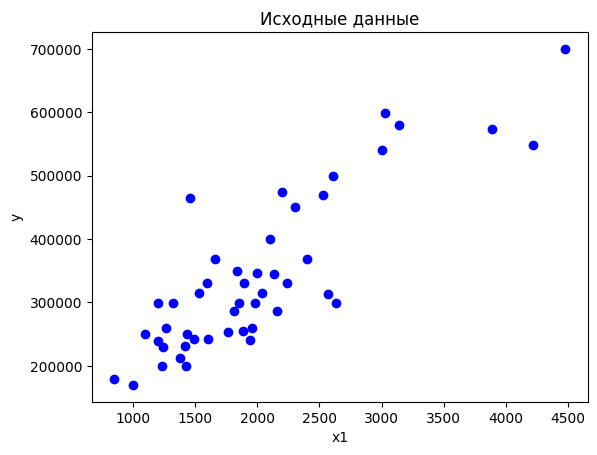

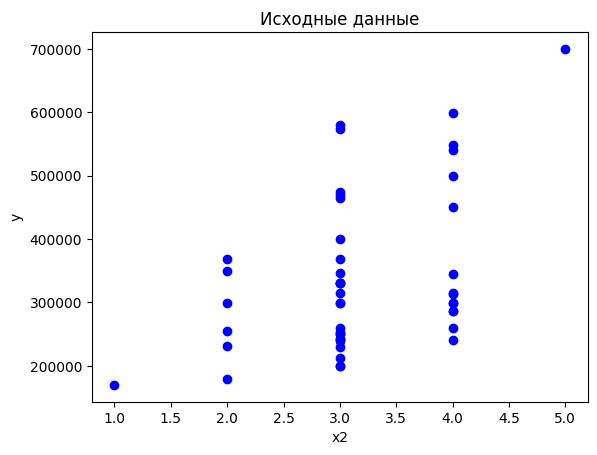

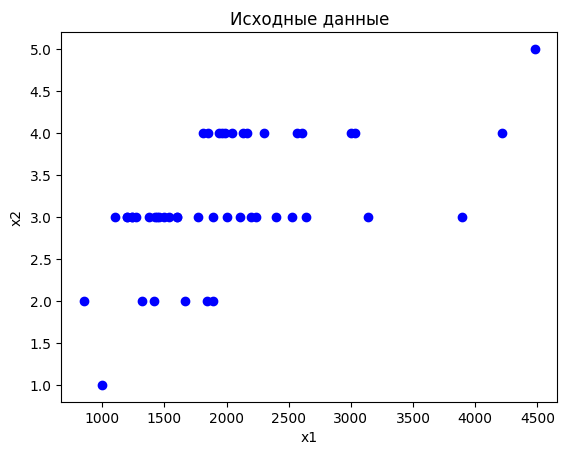

In [19]:
def visualize_data_points(x_axis, y_axis, x_axis_name: str, y_axis_name: str):
    plt.scatter(x_axis, y_axis, color='blue', label='Data points')
    plt.title('Исходные данные')
    plt.xlabel(x_axis_name)
    plt.ylabel(y_axis_name)
    plt.show()


visualize_data_points(X[:, 0], Y, "x1", "y")
visualize_data_points(X[:, 1], Y, "x2", "y")
visualize_data_points(X[:, 0], X[:, 1], "x1", "x2")


In [20]:
# Standardize data
def standardize_data(data):
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)
    return (data - means) / stds

X_standard = standardize_data(X)

# Add x0
ones_column = np.ones((X_standard.shape[0], 1))
X_with_ones = np.hstack((ones_column, X_standard))

In [27]:
# Split data
def split_data(x_data, y_data):
    train_size = int(x_data.shape[0] * 0.5)
    x_train, x_validate = x_data[:train_size], x_data[train_size:]
    y_train, y_validate = y_data[:train_size], y_data[train_size:]
    return x_train, y_train, x_validate, y_validate


X_train, y_train, X_validate, y_validate = split_data(X_with_ones, Y)
print(X_train.shape, y_train.shape)
print(X_train)

(23, 3) (23, 1)
[[ 1.         -0.71696639 -0.22609337]
 [ 1.         -0.9319237  -0.22609337]
 [ 1.          0.66817273 -0.22609337]
 [ 1.         -0.14332291 -1.5543919 ]
 [ 1.          2.40309445 -0.22609337]
 [ 1.          1.27107075  1.10220517]
 [ 1.         -0.74367706 -1.5543919 ]
 [ 1.         -0.0771822   1.10220517]
 [ 1.          0.5079087  -0.22609337]
 [ 1.         -0.96880986 -0.22609337]
 [ 1.          0.20518775  1.10220517]
 [ 1.         -0.01994505  1.10220517]
 [ 1.         -1.01459959 -0.22609337]
 [ 1.         -1.14560907 -0.22609337]
 [ 1.         -0.97262567 -0.22609337]
 [ 1.          0.25352135 -0.22609337]
 [ 1.         -0.42823675 -1.5543919 ]
 [ 1.         -0.0491996   1.10220517]
 [ 1.         -0.69025572 -0.22609337]
 [ 1.          0.77374348  1.10220517]
 [ 1.          0.72032214  1.10220517]
 [ 1.          2.81647389  1.10220517]
 [ 1.          3.15099326  2.4305037 ]]


In [22]:
def draw_errors(train_error_array, validate_error_array, alpha):
    epochs = np.arange(1, len(train_error_array) + 1)

    # Линия для train_error (сплошная линия)
    plt.plot(epochs, train_error_array, label='Train Error', color='blue', linewidth=2)

    # Линия для validate_error (пунктирная линия)
    plt.plot(epochs, validate_error_array, label='Validation Error', color='red', linewidth=2)

    # Настройка графика
    plt.title(f'График ошибки с коэффициентом обучения {round(alpha, 8)}')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()

    # Отображение графика
    plt.grid(True)
    plt.show()


def calculate_h(teta, x_matrix):
    return x_matrix @ (teta.T)


def calculate_teta_shift(h_matrix, x_matrix, y_array, spead: float):
    return spead * ((h_matrix - y_array).T @ x_matrix) / x_matrix.shape[0]


def calculate_error(x_matrix, y_array, teta):
    return ((y_array - calculate_h(teta, x_matrix)) ** 2).sum() / x_matrix.shape[0]


def learn_model(x_train_matrix, y_train_array, x_validate_matrix, y_validate_array, start_teta, epoch, learn,
                batch_size):
    teta = start_teta.copy()
    train_error_array = []
    validate_error_array = []
    data_size = x_train_matrix.shape[0]
    for i in range(epoch):
        # shuffled data
        shuffled_indices = np.random.permutation(data_size)
        x_matrix_shuffled = x_train_matrix[shuffled_indices]
        y_array_shuffled = y_train_array[shuffled_indices]

        # calculate teta shift by minibatch
        for start_batch_index in range(0, data_size, batch_size):
            x_batch = x_matrix_shuffled[start_batch_index:min(start_batch_index + batch_size, data_size)]
            y_batch = y_array_shuffled[start_batch_index:min(start_batch_index + batch_size, data_size)]
            h_array = calculate_h(teta, x_batch)
            teta = teta - calculate_teta_shift(h_array, x_batch, y_batch, learn)

        train_error = calculate_error(x_train_matrix, y_train_array, teta)
        validate_error = calculate_error(x_validate_matrix, y_validate_array, teta)
        train_error_array.append(train_error)
        validate_error_array.append(validate_error)

    return teta, train_error_array, validate_error_array


def learn_model_with_any_superparameters(x_train, y_train, x_validate, y_validated):
    epoch_values = np.linspace(100, 700, 3)
    learn_coefficients = np.linspace(0.01, 0.001, 2)
    # epoch_values = [400]
    # learn_coefficients = [0.01]
    for epoch in epoch_values:
        for learn_cof in learn_coefficients:
            start_teta = np.random.randint(-10 ** 6, 10 ** 6, size=X_train.shape[1])
            teta, train_error, validate_error = learn_model(x_train, y_train, x_validate, y_validated, start_teta,
                                                            int(epoch), learn_cof, 8)
            draw_errors(train_error, validate_error, learn_cof)
            print("Train error:", train_error[-1] / (10 ** 6), "Validate error:", validate_error[-1] / (10 ** 6))

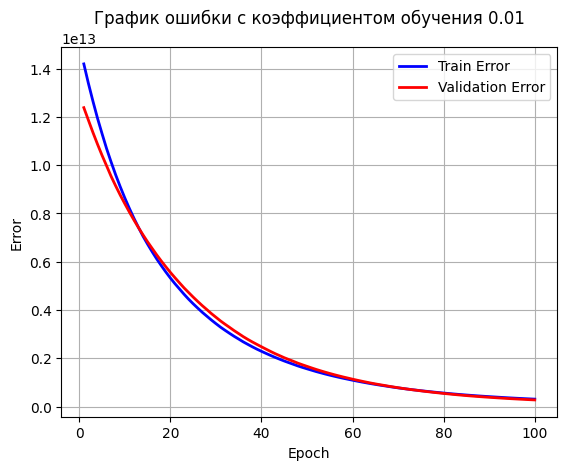

Train error: 307540.35446370504 Validate error: 274567.605026109


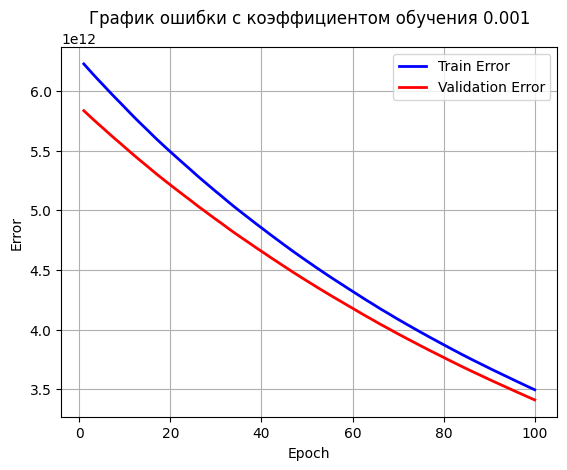

Train error: 3494479.967797312 Validate error: 3409308.3703105506


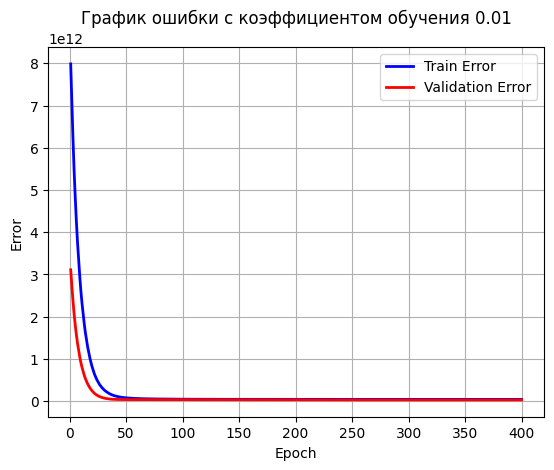

Train error: 40052.65819754115 Validate error: 27379.75995872876


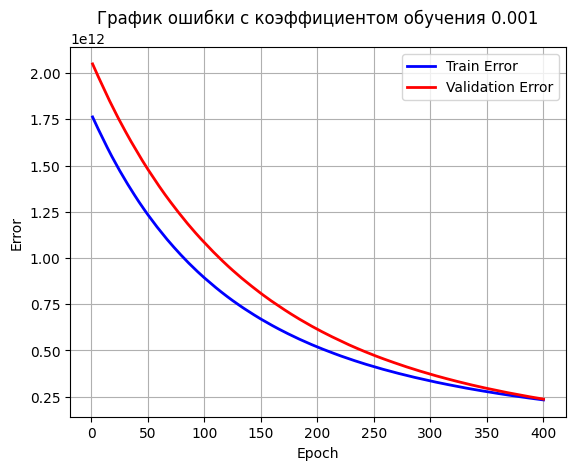

Train error: 232555.64139817958 Validate error: 236905.67784973927


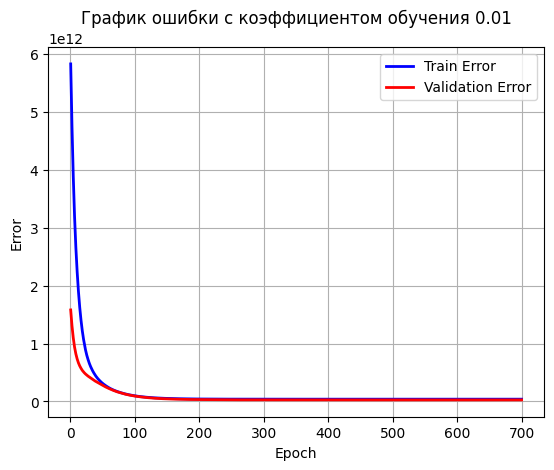

Train error: 40052.08629293688 Validate error: 27411.61203331889


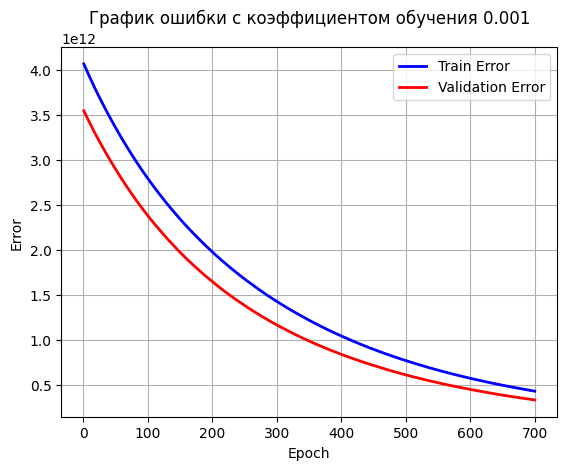

Train error: 435079.63987880753 Validate error: 337847.5650841269


In [23]:
learn_model_with_any_superparameters(X_train, y_train, X_validate, y_validate)

Добавим столбцы с расчётными значениями:
* x1^2
* x2^2

(47, 5) (47, 1)


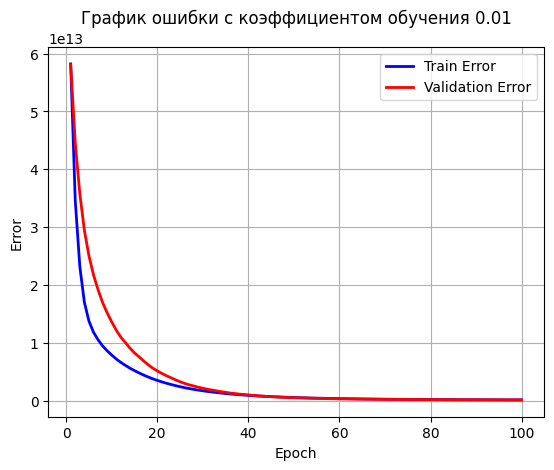

Train error: 119007.06325654915 Validate error: 121266.61623640955


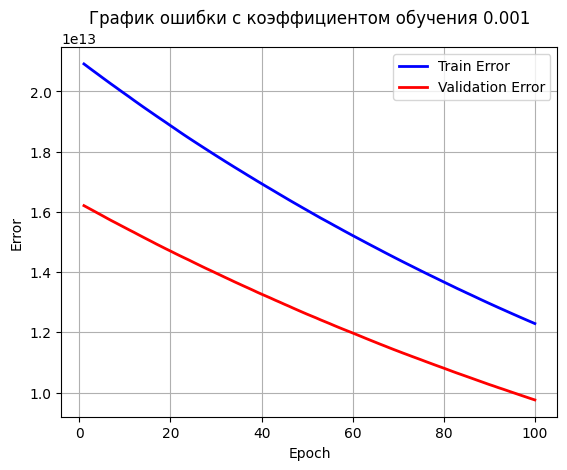

Train error: 12291863.02621523 Validate error: 9755311.663026296


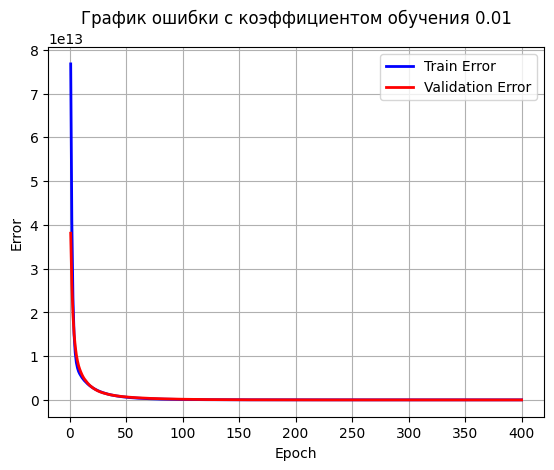

Train error: 39848.43338778318 Validate error: 27147.86386958121


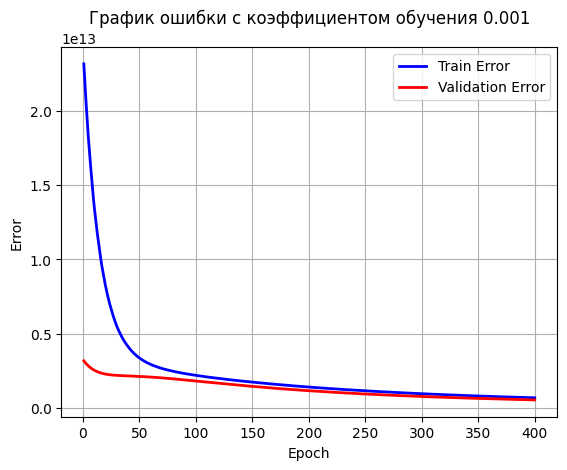

Train error: 683855.8865326062 Validate error: 541646.067505979


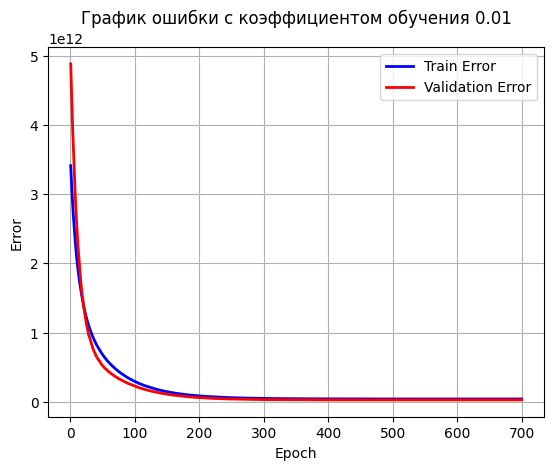

Train error: 39773.52168245334 Validate error: 26484.678929077192


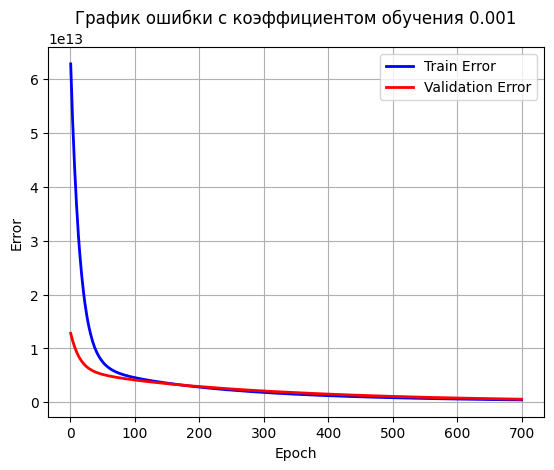

Train error: 426146.8093623889 Validate error: 559249.2011666417


In [24]:
X_extended = X_with_ones.copy()
X_extended = np.hstack((X_extended, (X_with_ones[:, 1] ** 2)[:, np.newaxis]))
X_extended = np.hstack((X_extended, (X_with_ones[:, 2] ** 2)[:, np.newaxis]))

print(X_extended.shape, Y.shape)
X_train, y_train, X_validate, y_validate = split_data(X_extended, Y)

learn_model_with_any_superparameters(X_train, y_train, X_validate, y_validate)

Добавим столбцы с расчётными значениями:
* x1^2
* x2^2
* x1^3
* x2^3

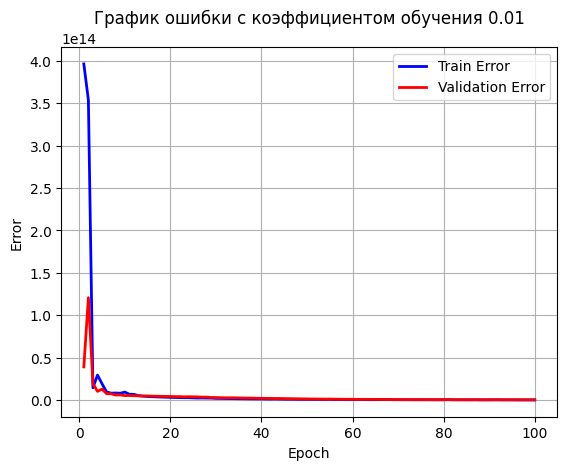

Train error: 162045.11535257293 Validate error: 293509.4979305637


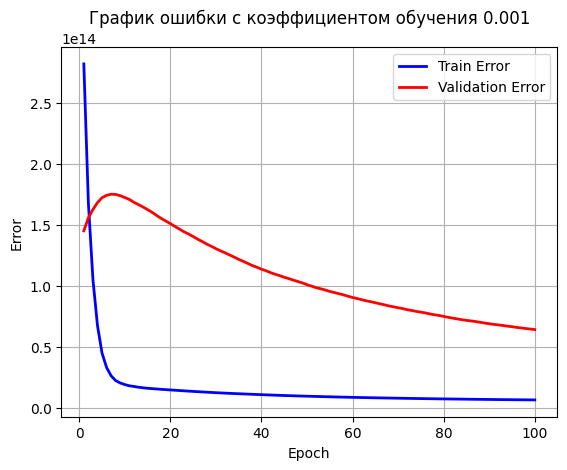

Train error: 6461935.818311717 Validate error: 64213504.41536675


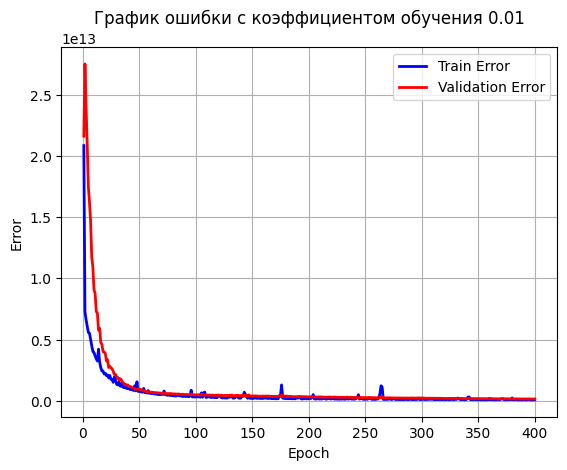

Train error: 76636.31559497525 Validate error: 144114.54710499922


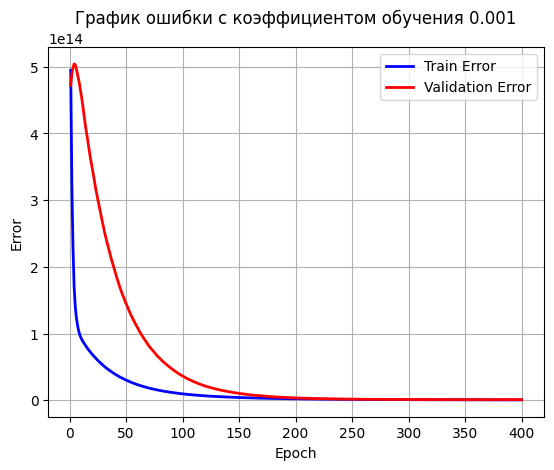

Train error: 483673.97460583533 Validate error: 1008001.4057700937


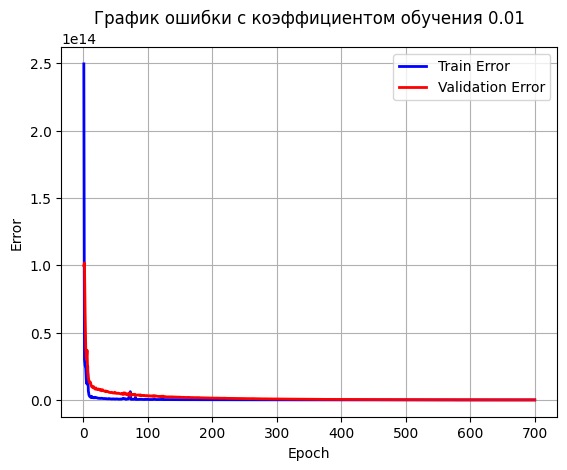

Train error: 47665.87292847388 Validate error: 69217.56334156932


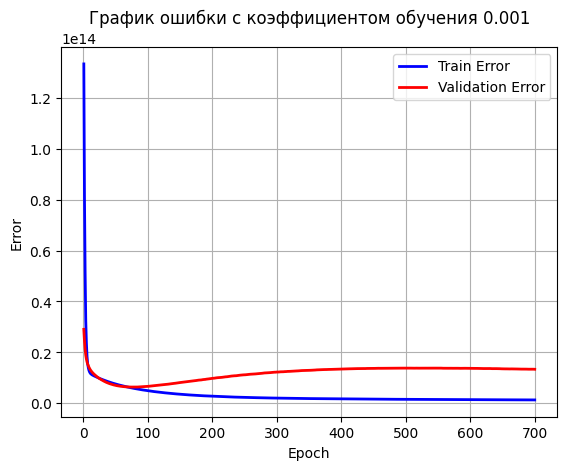

Train error: 1346040.518537686 Validate error: 13377883.41269963


In [25]:
X_extended = X_with_ones.copy()
X_extended = np.hstack((X_extended, (X_with_ones[:, 1] ** 2)[:, np.newaxis]))
X_extended = np.hstack((X_extended, (X_with_ones[:, 2] ** 2)[:, np.newaxis]))
X_extended = np.hstack((X_extended, (X_with_ones[:, 1] ** 3)[:, np.newaxis]))
X_extended = np.hstack((X_extended, (X_with_ones[:, 2] ** 3)[:, np.newaxis]))

X_train, y_train, X_validate, y_validate = split_data(X_extended, Y)

learn_model_with_any_superparameters(X_train, y_train, X_validate, y_validate)

Добавим столбцы с расчётными значениями:
* x1^2
* x2^2
* x1^3
* x2^3
* x1^2 * x2
* x2^2 * x1

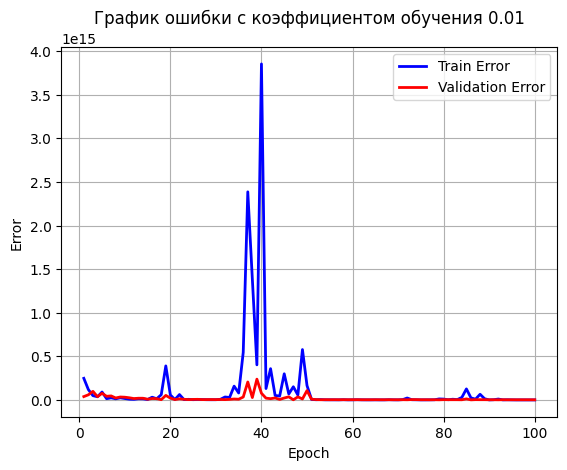

Train error: 823836.9507788173 Validate error: 2361681.4618902435


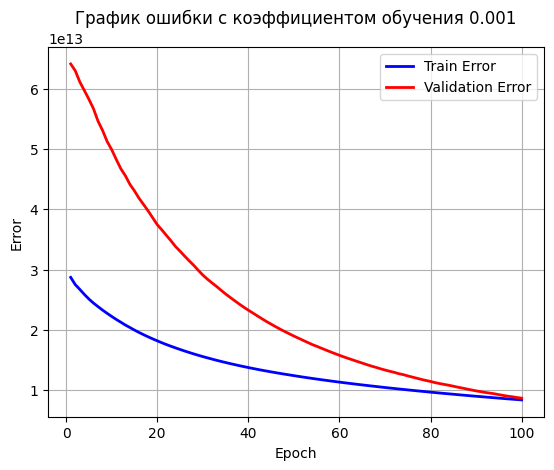

Train error: 8356680.441972209 Validate error: 8651810.67494462


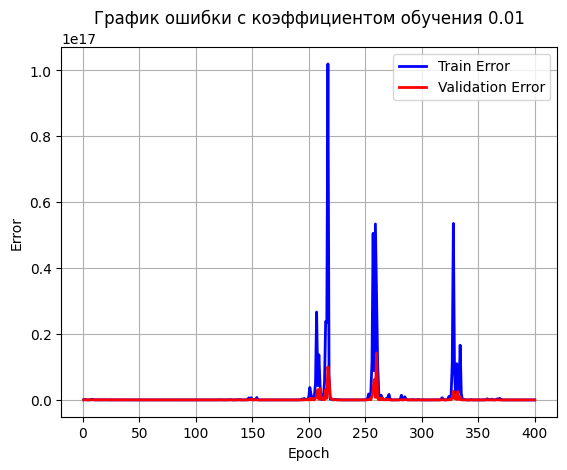

Train error: 1655560.984534579 Validate error: 1619181.7675337675


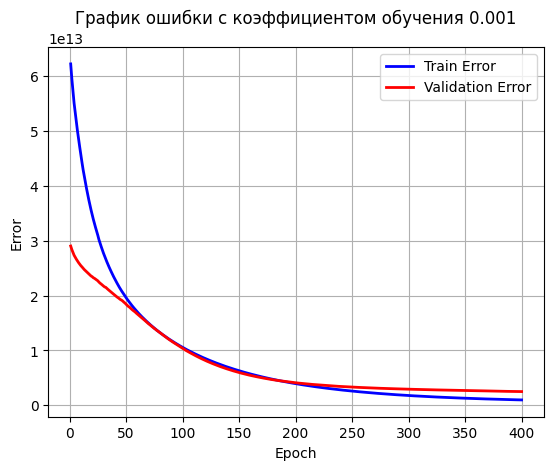

Train error: 974830.9671496744 Validate error: 2496137.5435932125


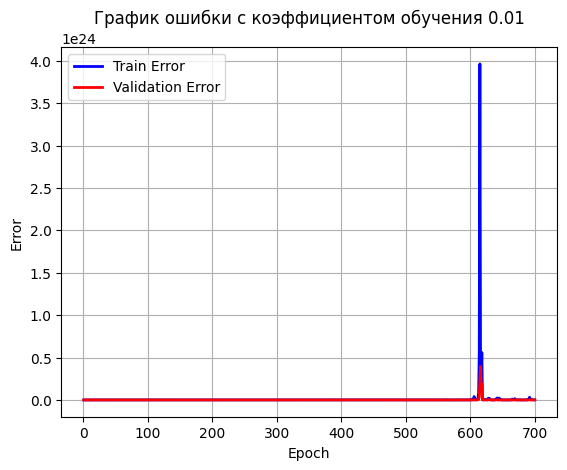

Train error: 1672166478622518.2 Validate error: 157781549481768.8


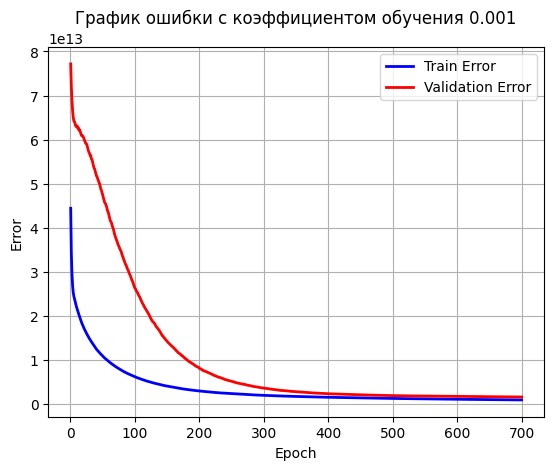

Train error: 913408.8750912232 Validate error: 1576836.5859435124


In [26]:
X_extended = X_with_ones.copy()
X_extended = np.hstack((X_extended, (X_with_ones[:, 1] * X_with_ones[:, 2])[:, np.newaxis]))
X_extended = np.hstack((X_extended, (X_with_ones[:, 1] ** 2)[:, np.newaxis]))
X_extended = np.hstack((X_extended, (X_with_ones[:, 2] ** 2)[:, np.newaxis]))
X_extended = np.hstack((X_extended, (X_with_ones[:, 1] ** 3)[:, np.newaxis]))
X_extended = np.hstack((X_extended, (X_with_ones[:, 2] ** 3)[:, np.newaxis]))
X_extended = np.hstack((X_extended, ((X_with_ones[:, 1] ** 2) * X_with_ones[:, 2])[:, np.newaxis]))
X_extended = np.hstack((X_extended, ((X_with_ones[:, 2] ** 2) * X_with_ones[:, 1])[:, np.newaxis]))


X_train, y_train, X_validate, y_validate = split_data(X_extended, Y)

learn_model_with_any_superparameters(X_train, y_train, X_validate, y_validate)